<a href="https://colab.research.google.com/github/dayaYanez/MLTSA25_DYanez/blob/main/HW7/autoencoder_time_series_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder for time series
an autoencoder is a deep neural network that reproduces input data

it does so by progressively shrinking the size of the layers from the input size to a bottle neck and then expanding them back progressively to the initial size

note: the input and target are the same!

put your imports in the top cell

In [1]:
#Deep leaarning imports
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pylab as pl
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense

get the data by cloaning the repo https://github.com/nlandolfi/acc2022treelinearcascades_stocks.git

In [2]:
!git clone https://github.com/nlandolfi/acc2022treelinearcascades_stocks.git

Cloning into 'acc2022treelinearcascades_stocks'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 0), reused 40 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.25 MiB | 4.57 MiB/s, done.


These are stock price time series. Use the " Volume" column as your chosen time series

In [3]:
ls

acc2022treelinearcascades_stocks/  sample_data/


In [4]:
ls acc2022treelinearcascades_stocks/data

aapl.csv  cat.csv   dis.csv  hon.csv   jpm.csv  mrk.csv   trv.csv  wba.csv
amgn.csv  crm.csv   dow.csv  ibm.csv   ko.csv   msft.csv  unh.csv  wmt.csv
axp.csv   csco.csv  gs.csv   intc.csv  mcd.csv  nke.csv   v.csv
ba.csv    cvx.csv   hd.csv   jnj.csv   mmm.csv  pg.csv    vz.csv


check that all files have the same length. The system command `wc -l returns` the  number of lines (stands for "word count -lines")

In [5]:
!wc -l acc2022treelinearcascades_stocks/data/*
!rm acc2022treelinearcascades_stocks/data/dow.csv #removing this one because it has 542 instead of 2516. Maybe make sure that's right before submitting?

   2516 acc2022treelinearcascades_stocks/data/aapl.csv
   2516 acc2022treelinearcascades_stocks/data/amgn.csv
   2516 acc2022treelinearcascades_stocks/data/axp.csv
   2516 acc2022treelinearcascades_stocks/data/ba.csv
   2516 acc2022treelinearcascades_stocks/data/cat.csv
   2516 acc2022treelinearcascades_stocks/data/crm.csv
   2516 acc2022treelinearcascades_stocks/data/csco.csv
   2516 acc2022treelinearcascades_stocks/data/cvx.csv
   2516 acc2022treelinearcascades_stocks/data/dis.csv
    542 acc2022treelinearcascades_stocks/data/dow.csv
   2516 acc2022treelinearcascades_stocks/data/gs.csv
   2516 acc2022treelinearcascades_stocks/data/hd.csv
   2516 acc2022treelinearcascades_stocks/data/hon.csv
   2516 acc2022treelinearcascades_stocks/data/ibm.csv
   2516 acc2022treelinearcascades_stocks/data/intc.csv
   2516 acc2022treelinearcascades_stocks/data/jnj.csv
   2516 acc2022treelinearcascades_stocks/data/jpm.csv
   2516 acc2022treelinearcascades_stocks/data/ko.csv
   2516 acc2022treelinearcas

In [6]:
#create a list of all files you want to load
files = glob.glob("acc2022treelinearcascades_stocks/data/*")
#pd.read_csv(files[0])
files[1]

'acc2022treelinearcascades_stocks/data/dis.csv'

In [7]:
#create a numpy array to host the data
data = np.zeros((np.shape(files)[0],len(pd.read_csv(files[1])))) # do not use hard coded numbers, use values calculated on the spot from the variables you have: the number of and shape of the files

In [8]:
data.shape

(29, 2516)

 read in all the data into the array

In [9]:
#remove
for i,f in tqdm(enumerate(files)):
    df = pd.read_csv(f)
    data[i,:] = df[' Volume'].values

29it [00:00, 40.56it/s]


plot the time series

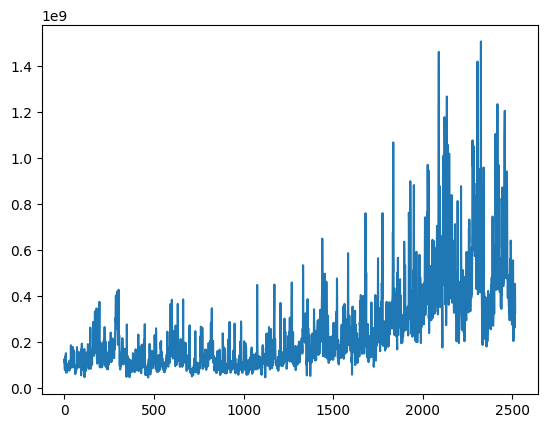

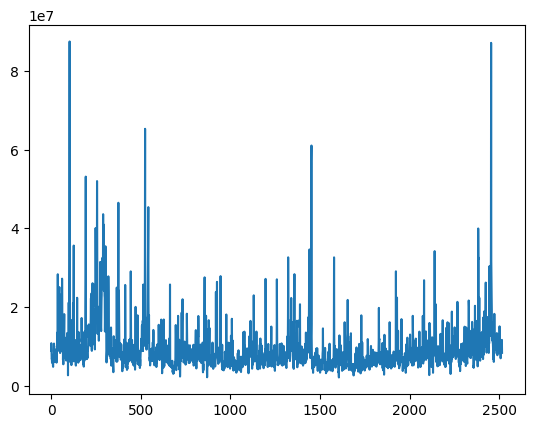

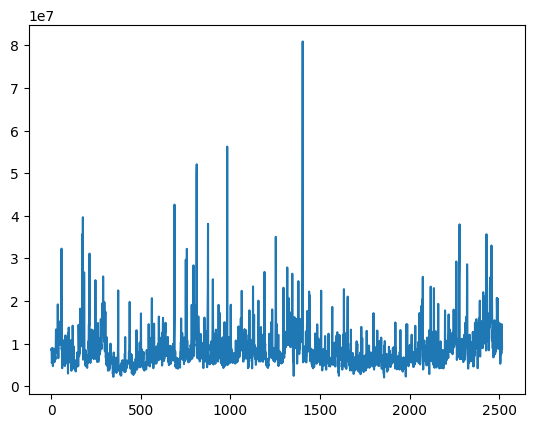

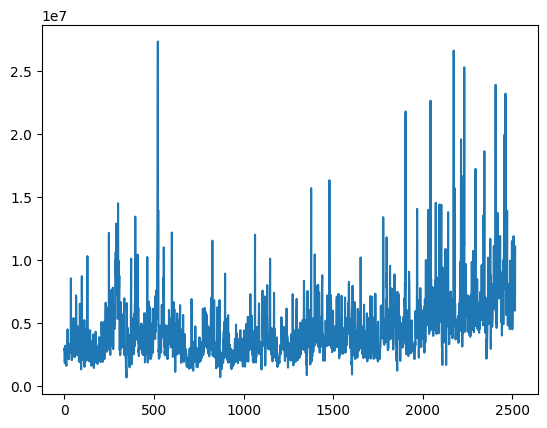

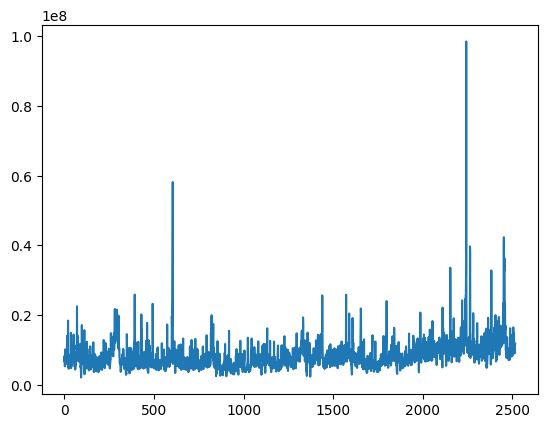

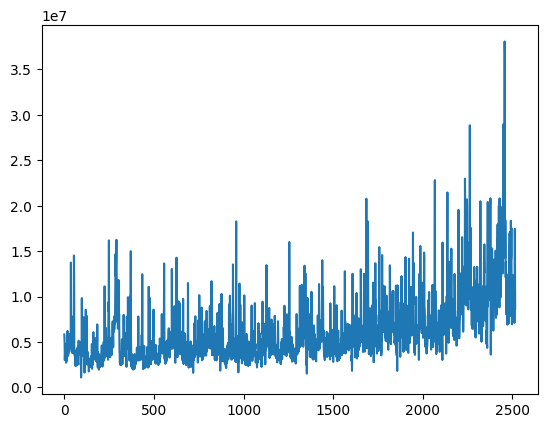

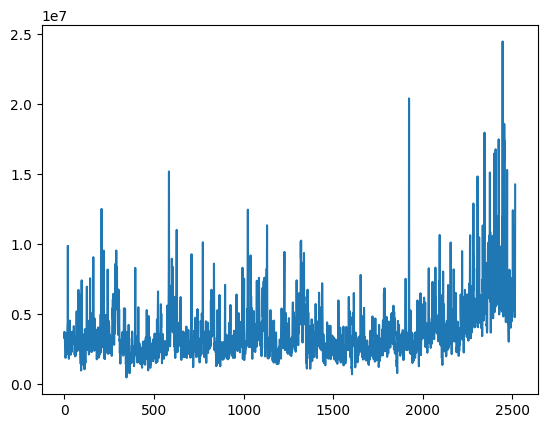

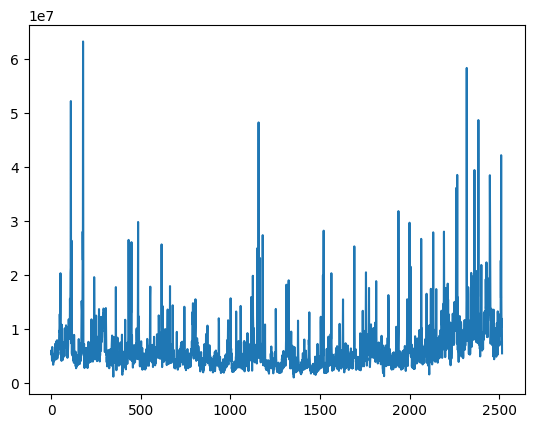

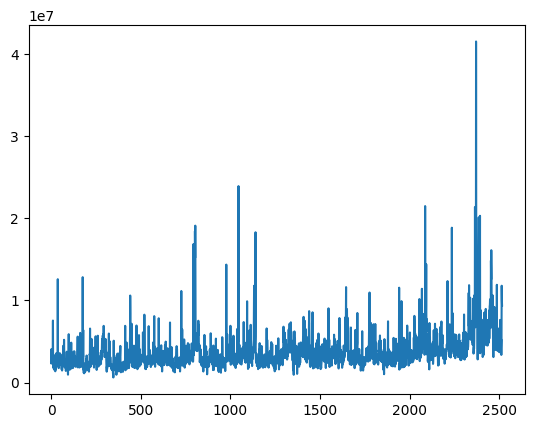

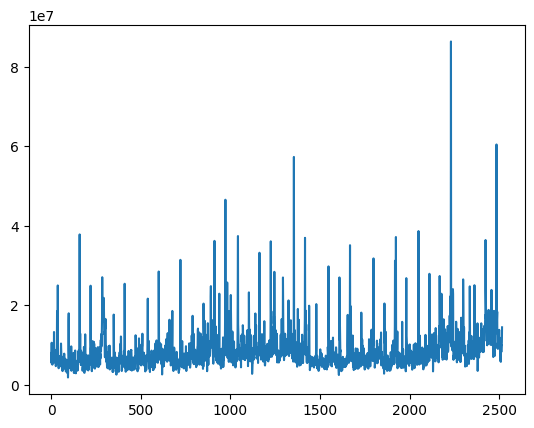

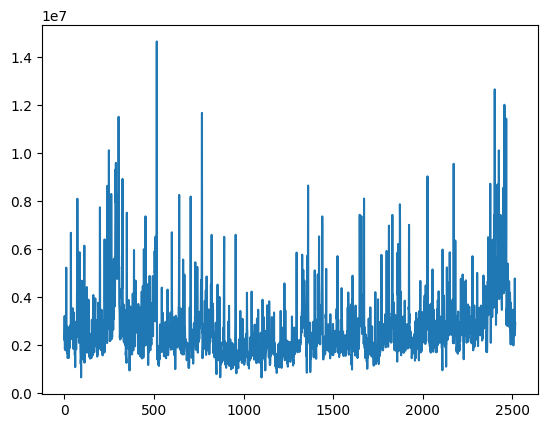

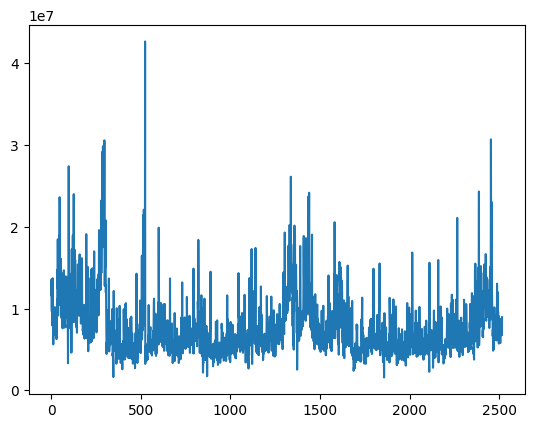

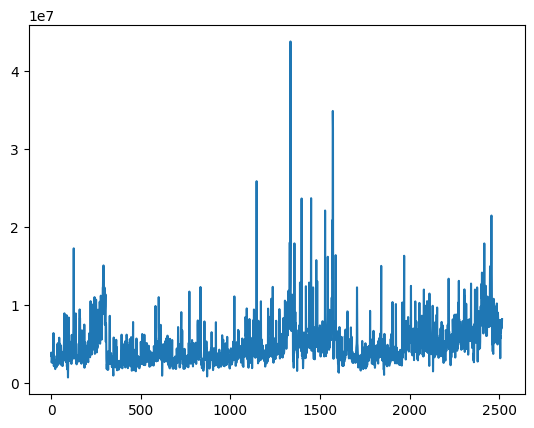

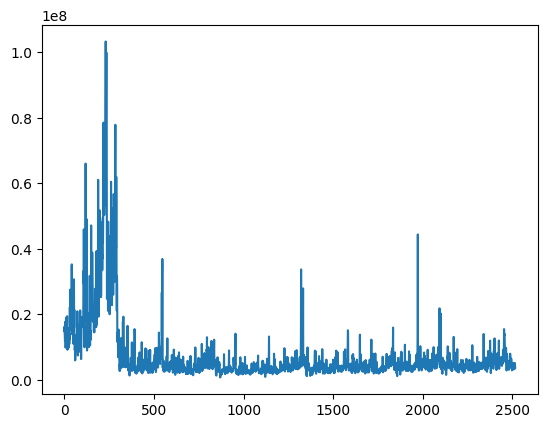

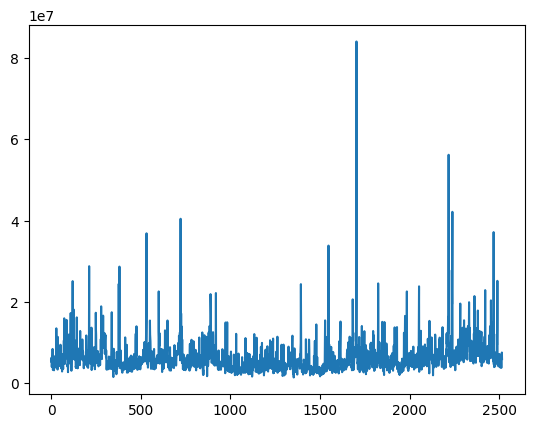

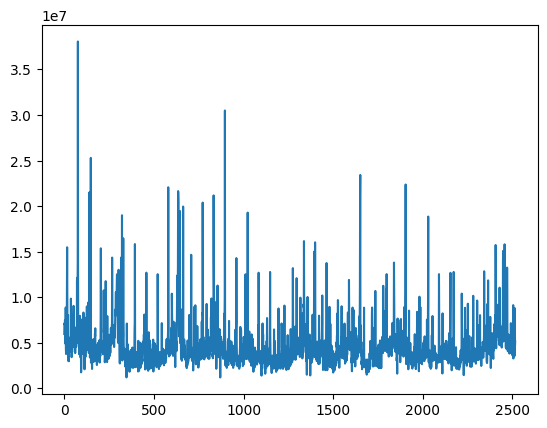

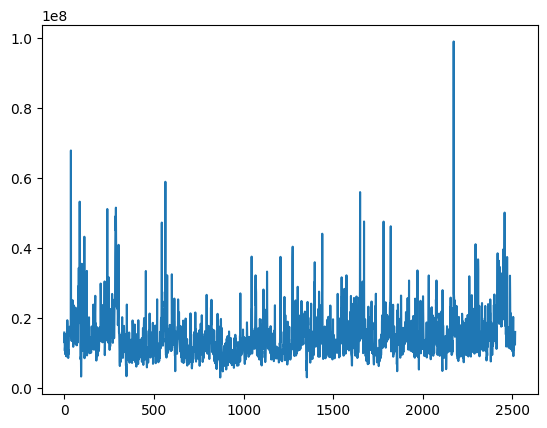

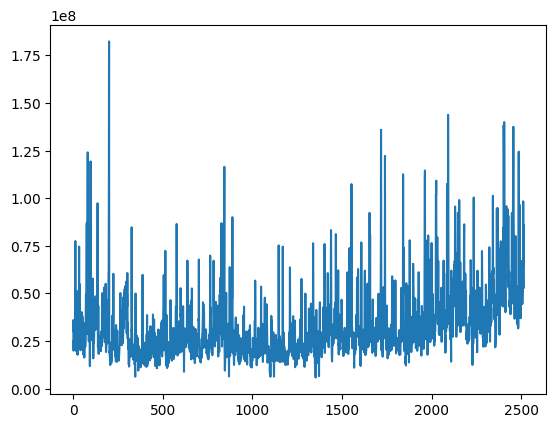

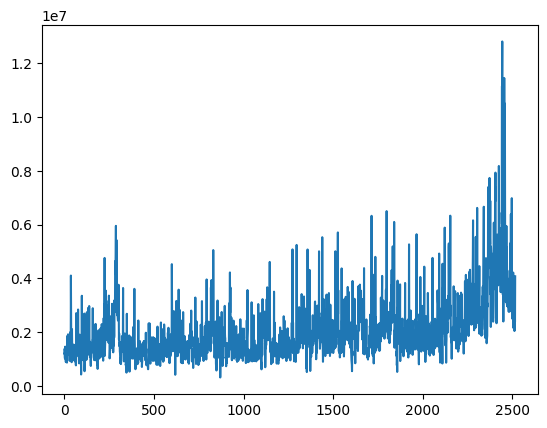

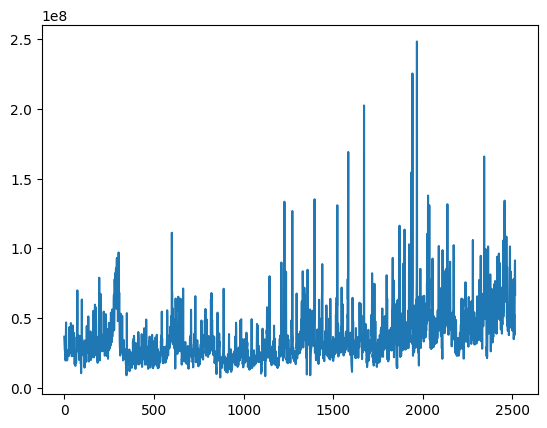

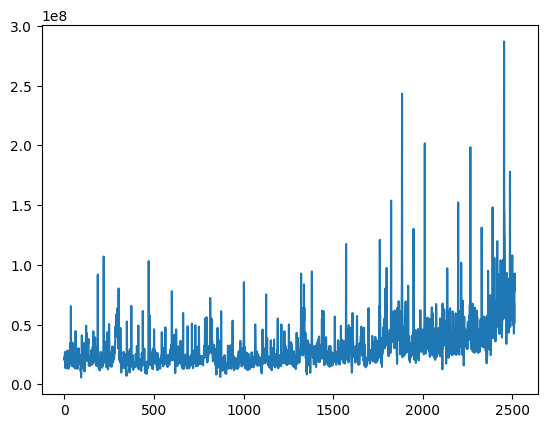

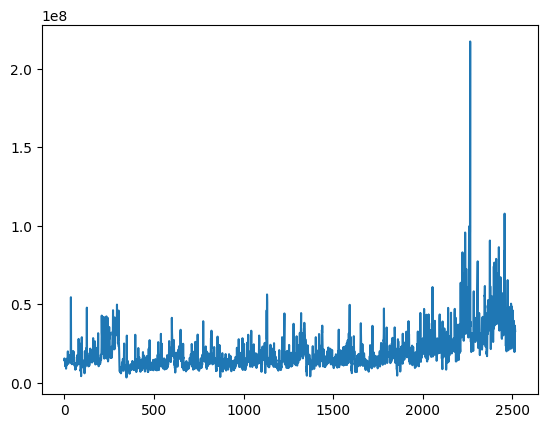

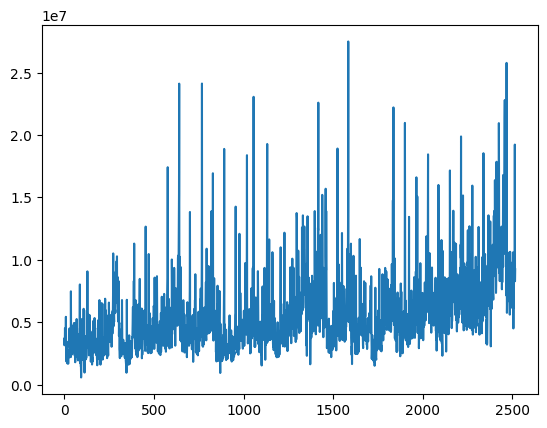

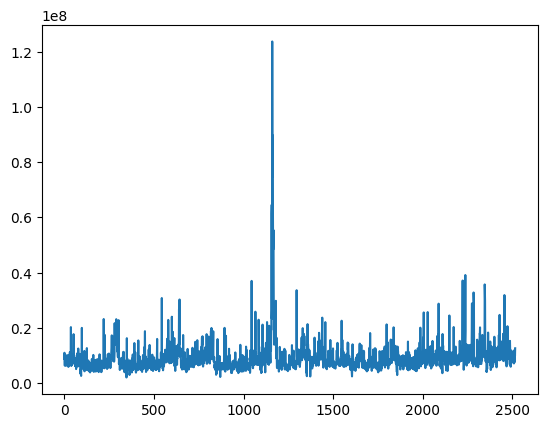

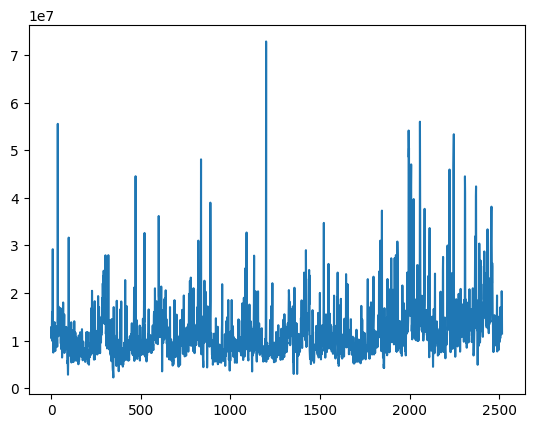

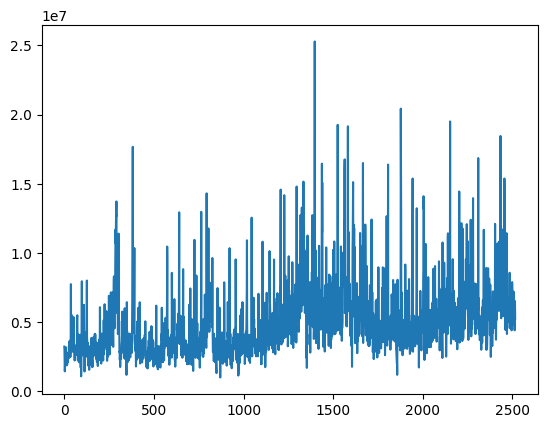

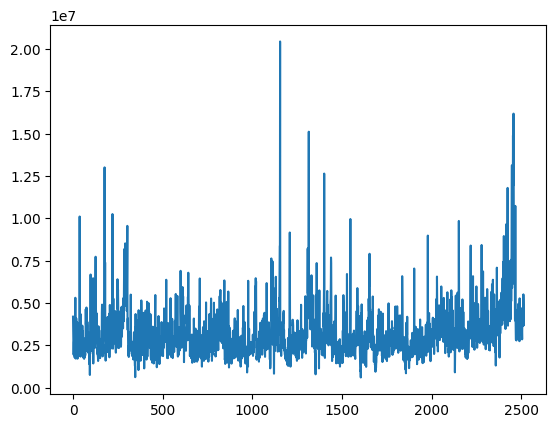

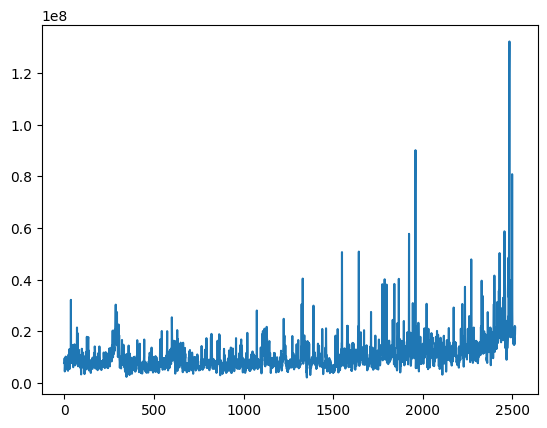

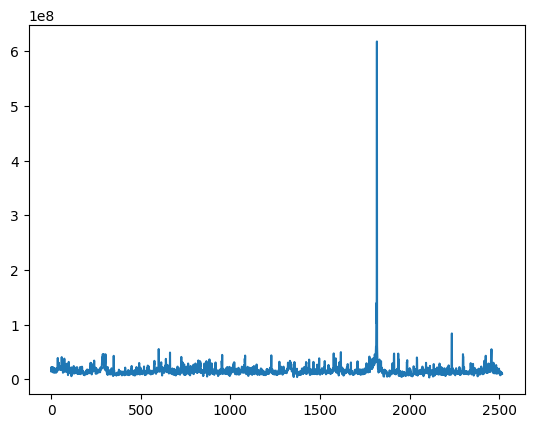

In [32]:
for i in range(data.shape[0]):
  pl.plot(data[i,:])
  pl.show()
#pl.plot(data)

**Figure 1:** Time series of raw volume for a group of equities. Plotted over a similar time period (about 2,500 trading days), each subplot displays the historical daily trading volume of a distinct stock. Stocks vary significantly in terms of magnitude and volatility; some show steady rises in activity over time, while others show enormous spikes that are probably the result of significant market events or business activities. These differences demonstrate how crucial per-series normalization is before autoencoder training.

scale the time series appropriately
hint: use Standard Scaler to save the mean and standard deviation of each time series, that way you can apply them later to your predicted results

In [11]:
scaler = StandardScaler()

data_t = data.transpose()
scaled_data_t = scaler.fit_transform(data_t)
scaled_data = scaled_data_t.transpose()

print(scaler.mean_)

[2.41918808e+08 9.22106420e+06 8.56753041e+06 4.47784854e+06
 8.38605635e+06 6.13210239e+06 3.69958000e+06 6.39931196e+06
 3.68032742e+06 8.38845291e+06 2.70803716e+06 7.59459024e+06
 4.82569939e+06 7.31825091e+06 6.22716013e+06 4.64859694e+06
 1.44888552e+07 3.23061745e+07 2.00906164e+06 3.61821291e+07
 3.04478866e+07 1.95325344e+07 5.49183710e+06 9.05137382e+06
 1.16112013e+07 4.83503569e+06 3.20954830e+06 1.07715065e+07
 1.57255425e+07]


In [12]:
scaled_data.mean(axis=1)

array([ 1.35556643e-16, -6.21301279e-17,  8.47229017e-17,  1.58149417e-16,
        9.03710952e-17, -9.03710952e-17, -6.77783214e-17,  0.00000000e+00,
       -1.12963869e-16, -6.77783214e-17,  1.58149417e-16,  2.25927738e-17,
       -4.51855476e-17,  0.00000000e+00,  7.90747083e-17,  2.54168705e-17,
        3.38891607e-17,  4.51855476e-17,  9.03710952e-17, -1.12963869e-16,
       -4.51855476e-17, -9.03710952e-17, -6.77783214e-17,  5.36578378e-17,
       -9.03710952e-17, -1.35556643e-16, -1.12963869e-17, -9.03710952e-17,
        7.20144665e-17])

In [13]:
scaled_data.std(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

split traiing and testimg data

In [14]:
training_set, test_set = train_test_split(scaled_data, test_size=0.2)
X_train, y_train = training_set, training_set
X_test, y_test = test_set, test_set

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23, 2516), (6, 2516), (23, 2516), (6, 2516))

build the model. It shoudl be a MLP (Multi Layer Perceptron) thus the only kind of layers you need are Dense layers (`from keras.layers import Dense`). Keep in mind the size of the initial time series. By definition a autoencoder will start with large layers, shdink the number of neurons in each layer progressively till a "bottle neck" layer (e.g. 32 neurons, but try what works). then add progressively larger layers until the last layer has the same size as the imput data. Use `relu` activation functions for all layers but the last one, which shoudl be `linear`

In [16]:
input_size = scaled_data.shape[1]
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(input_size,)))
model.add(Dense(128, activation='relu', input_shape=(input_size,)))
model.add(Dense(64, activation='relu', input_shape=(input_size,)))
model.add(Dense(32, activation='relu', input_shape=(input_size,)))
model.add(Dense(64, activation='relu', input_shape=(input_size,)))
model.add(Dense(128, activation='relu', input_shape=(input_size,)))
model.add(Dense(512, activation='linear', input_shape=(input_size,)))
model.add(Dense(2516, activation='linear', input_shape=(input_size,)))
#model.add(Dense(input_size, activation='linear', input_shape=(input_size,)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
input_size

2516

In [18]:
# this is a call back that ensures you stop training when the validation loss stops improving (es)
# ad saves the model if it is better than the model at the previous training epoch (mc)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


write the `model.compile` command passing to the compile function the `adam` optimizer and `mean_squared_error` loss function

```model.compile(...```


In [19]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,288,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2516)           │     1,290,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,731,892 (10.42 MB)

 Trainable params: 2,731,892 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

write the model.fit command. This will start the training of the neural network.
pass to the fit() function the following arguments:
- the imput data: that is your data train pd.array
- the desired output.... pay attention! this is an autoencoder so it should reproduce with fidelity the input data!
- create an internal validation set: this will split the training data so that at each epoch you can assess the model performance on unseen data `validation_split=0.1`
- set up training for 200 epochs with the `epoch=200` argument
- set the `batch_size`. I set it to 10, you can try different things. Larger batch makes a faster code the has higher risk of overfitting
- set `verbose=1`
- add the callbacks with `callbacks=[es, mc]


```training = model.fit(.....```



In [21]:
#remove
training = model.fit(x=X_train, y=y_train, validation_split=0.1, epochs=200, batch_size=10, verbose=1, callbacks=[es, mc])

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.0025
Epoch 1: val_loss improved from inf to 0.91973, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - loss: 0.9982 - val_loss: 0.9197
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9071
Epoch 2: val_loss improved from 0.91973 to 0.87526, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.8780 - val_loss: 0.8753
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8538
Epoch 3: val_loss improved from 0.87526 to 0.71636, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.8070 - val_loss: 0.7164
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6580
Epoch 4: val_loss improved from 0.71636 to 0.69704, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.6887 - val_loss: 0.6970
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6867
Epoch 5: val_loss improved from 0.69704 to 0.67784, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.6840 - val_loss: 0.6778
Epoch 6/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.6966
Epoch 6: val_loss improved from 0.67784 to 0.65735, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.6754 - val_loss: 0.6573
Epoch 7/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6552
Epoch 7: val_loss improved from 0.65735 to 0.64791, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.6390 - val_loss: 0.6479
Epoch 8/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.6195
Epoch 8: val_loss improved from 0.64791 to 0.63104, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.6089 - val_loss: 0.6310
Epoch 9/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.5858
Epoch 9: val_loss improved from 0.63104 to 0.62632, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.5858 - val_loss: 0.6263
Epoch 10/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.5545
Epoch 10: val_loss did not improve from 0.62632
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.5554 - val_loss: 0.6324
Epoch 11/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5286
Epoch 11: val_loss improved from 0.62632 to 0.62218, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.5323 - val_loss: 0.6222
Epoch 12/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.5222
Epoch 12: val_loss improved from 0.62218 to 0.62115, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - loss: 0.5064 - val_loss: 0.6211
Epoch 13/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.4620
Epoch 13: val_loss improved from 0.62115 to 0.61657, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.4704 - val_loss: 0.6166
Epoch 14/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4571
Epoch 14: val_loss improved from 0.61657 to 0.61601, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.4499 - val_loss: 0.6160
Epoch 15/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4277
Epoch 15: val_loss did not improve from 0.61601
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4201 - val_loss: 0.6263
Epoch 16/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3711
Epoch 16: val_loss improved from 0.61601 to 0.61426, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3891 - val_loss: 0.6143
Epoch 17/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3774
Epoch 17: val_loss did not improve from 0.61426
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3737 - val_loss: 0.6151
Epoch 18/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3594
Epoch 18: val_loss improved from 0.61426 to 0.61378, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3527 - val_loss: 0.6138
Epoch 19/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2977
Epoch 19: val_loss improved from 0.61378 to 0.61290, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.3196 - val_loss: 0.6129
Epoch 20/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3013
Epoch 20: val_loss improved from 0.61290 to 0.60868, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3045 - val_loss: 0.6087
Epoch 21/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2715
Epoch 21: val_loss did not improve from 0.60868
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2811 - val_loss: 0.6128
Epoch 22/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2797
Epoch 22: val_loss did not improve from 0.60868
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2732 - val_loss: 0.6103
Epoch 23/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.2330
Epoch 23: val_loss did not improve from 0.60868
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2447 - val_loss: 0.6113
Epoch 24/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2493
Epoch 24: val_loss did not improve from 0.60868
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2376 - val_loss: 0.6175
Epoch 25/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2434
Epoch 25: val_loss did not improve from 0.60868
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2258 - val_loss: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.2001 - val_loss: 0.6072
Epoch 27/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2159
Epoch 27: val_loss did not improve from 0.60715
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1972 - val_loss: 0.6119
Epoch 28/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1413
Epoch 28: val_loss improved from 0.60715 to 0.60708, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.1645 - val_loss: 0.6071
Epoch 29/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1878
Epoch 29: val_loss did not improve from 0.60708
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1730 - val_loss: 0.6090
Epoch 30/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1931
Epoch 30: val_loss did not improve from 0.60708
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1663 - val_loss: 0.6181
Epoch 31/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0551
Epoch 31: val_loss did not improve from 0.60708
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1123 - val_loss: 0.6102
Epoch 32/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1459
Epoch 32: val_loss did not improve from 0.60708
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1378 - val_loss: 0.6105
Epoch 33/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1538
Epoch 33: val_loss did not improve from 0.60708
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1321 - val_loss: 0

In [22]:
training.history.keys() # this stores the value of the loss at each epoch so you can plot it

dict_keys(['loss', 'val_loss'])

In [24]:
plot the loss function!!

SyntaxError: invalid syntax (<ipython-input-24-f9a12ca63001>, line 1)

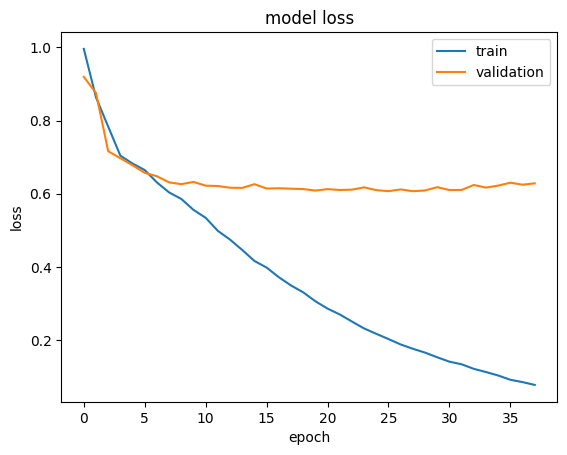

In [25]:
pl.plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# add axis labels and legend!!

**Figure 2:** The autoencoder model's training and validation loss curves span 37 epochs. The model is successfully fitting the training data as the training loss (blue) steadily declines. The validation loss (orange), on the other hand, plateaus early and stays comparatively flat, indicating that overfitting starts after around five epochs. This behavior emphasizes how crucial it is to stop early in order to avoid more overfitting and maintain generalization to new data.

CAPTION!!

plot (visualize) the prediction and the ground truth for the test data. What do you see? where is the model succesful where is it not?

In [26]:
model.predict?

In [27]:
prediction = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [28]:
prediction.shape

(6, 2516)

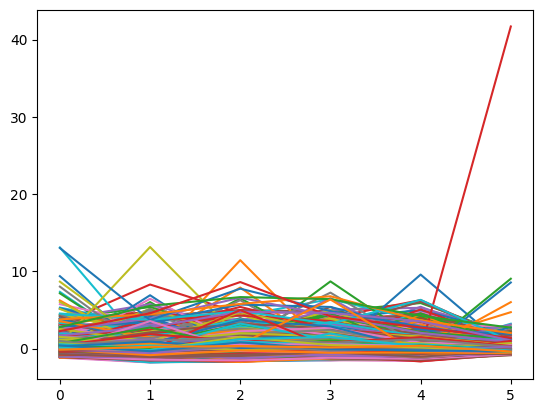

In [29]:
pl.plot(prediction)
pl.plot(X_test)
pl.show()

**Figure 3:** Plots of the test set's ground truth and anticipated time series are superimposed. One time step over several stock volume sequences is represented by each colored line. Notable outliers, such as the abrupt rise at the last time step, show that the autoencoder has trouble with infrequent, high-magnitude occurrences, even when the majority of predictions closely match their respective targets. This might indicate that the dataset needs better regularization, bottleneck adjustment, or outlier management.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


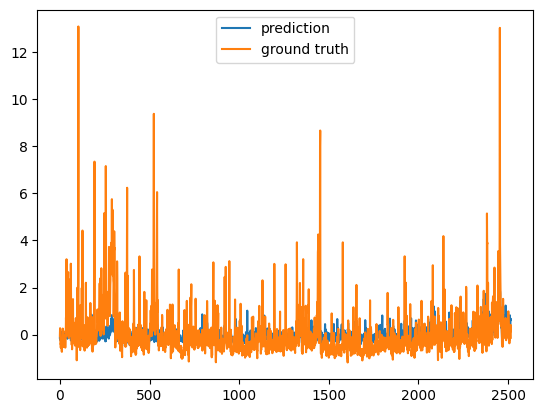

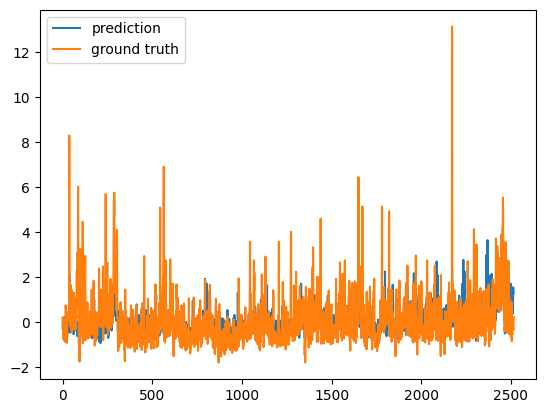

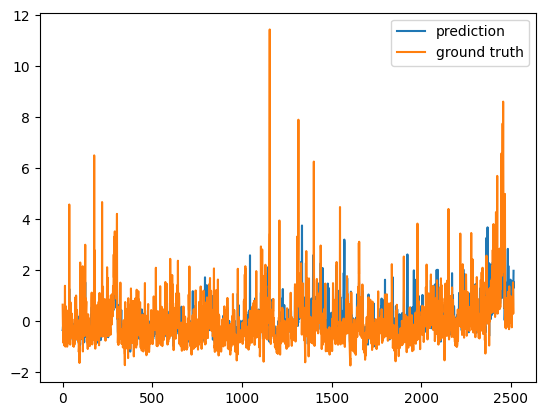

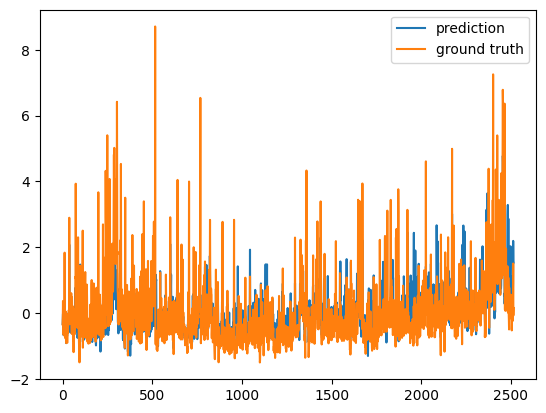

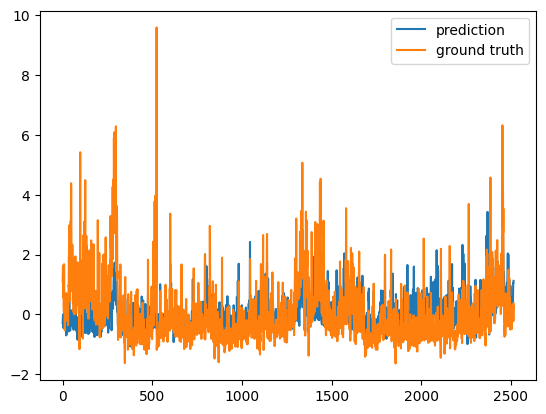

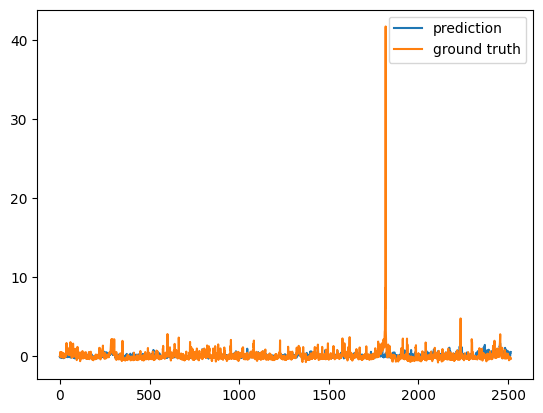

In [33]:
prediction = model.predict(X_test)
for i,_ in enumerate(X_test):
  pl.plot(prediction[i], label = 'prediction')
  pl.plot(X_test[i], label = 'ground truth', linestyle = '-')
  pl.legend()
  pl.show()

**Figure 4:** Comparison between predicted and ground truth time series on selected test samples. The model demonstrates reasonable reconstruction accuracy for general trends and moderate fluctuations. However, sharp peaks and rare high-volume events are consistently underestimated or smoothed out, indicating the autoencoder’s limited capacity for capturing extreme variations. This suggests the potential need for a more expressive model, outlier handling, or custom loss functions tailored to volatility.

CAPTION!!

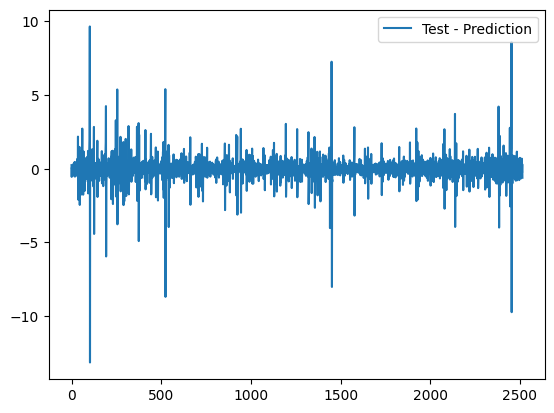

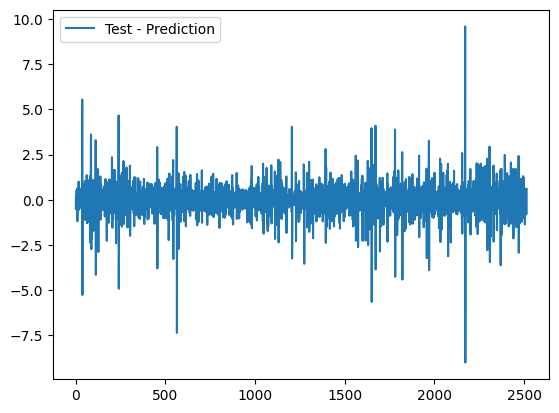

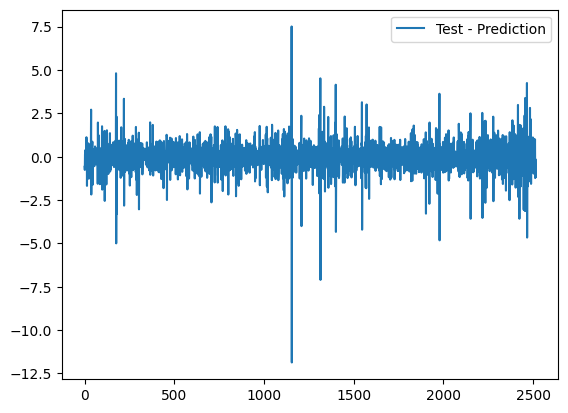

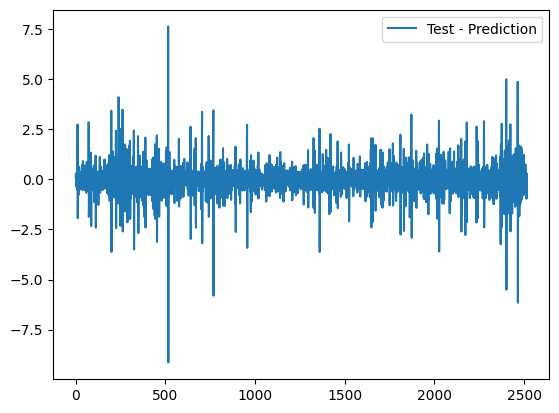

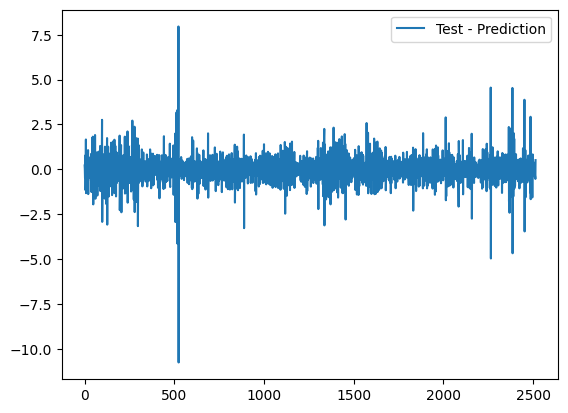

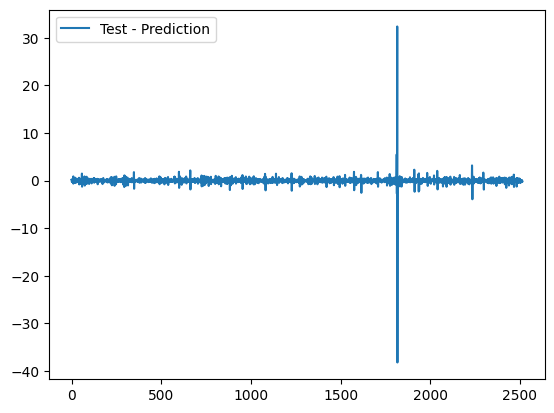

In [34]:
for i,_ in enumerate(X_test):
  pl.plot(np.diff(X_test[i]-prediction[i]), label = 'Test - Prediction')
  #pl.plot(X_test[i], label = 'ground truth', linestyle = '-')
  pl.legend()
  pl.show()

**Figure 5:**first-order variation in the test-prediction residuals for each test sample. These plots show the places where the stock volume time series cannot be reliably reconstructed by the autoencoder. Sharp spikes indicate periods of poor prediction, usually around sudden changes in volume, whereas the majority of differences stay near zero. This suggests that the model has trouble capturing high-frequency variations or outliers. This picture encourages more research into anomaly-robust designs or the incorporation of temporal dynamics.